# Drive Connection

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installation

In [23]:
%%capture
!pip install torch torchvision pennylane --quiet
!pip install reportlab
!pip install torchview
!pip install torchviz



# Imports

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pennylane as qml
from pennylane import numpy as np


# Quantum Circuit

In [6]:
n_qubits = 4
n_layers = 2
n_classes = 2   # change this to match your dataset

# PennyLane device (simulator)
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_circuit(inputs, weights):
    # Encode classical inputs into quantum state
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch")
quantum_layer = qml.qnn.TorchLayer(qnode, weight_shapes)


# Hybrid Model

In [7]:
import torchvision.models as models

class HybridResNet18(nn.Module):
    def __init__(self, num_classes=n_classes):
        super(HybridResNet18, self).__init__()

        # Pretrained ResNet18
        self.resnet = models.resnet18(pretrained=True)

        # Remove last fc, keep features
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])

        # Classical → Quantum interface
        self.fc1 = nn.Linear(self.resnet.fc.in_features, n_qubits)
        self.quantum = quantum_layer
        self.fc2 = nn.Linear(n_qubits, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.quantum(x)
        x = self.fc2(x)
        return x

model = HybridResNet18(num_classes=n_classes)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


# Dataset loading

In [8]:
from torchvision import datasets

# Define transforms (resize to 224x224 for ResNet18)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load your dataset
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/MammoML/ThermalResFolder", transform=transform)

# Split into train/val (80-20 split for example)
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=2)
valloader   = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=False, num_workers=2)

# Number of classes from your dataset
n_classes = len(dataset.classes)
print("Classes:", dataset.classes)  # should print ['healthy', 'sick']


Classes: ['Healthy', 'sick']


# Model Definition

In [9]:
model = HybridResNet18(num_classes=n_classes)

# Training Loop

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to device
model = model.to(device)

# Define loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(valloader)
    epoch_val_acc = 100 * correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {epoch_train_loss:.3f}, Train Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.3f}, Val Acc: {epoch_val_acc:.2f}%")

print("Training Finished ✅")


Using device: cuda
Epoch [1/15] Train Loss: 0.600, Train Acc: 49.65% | Val Loss: 0.531, Val Acc: 51.40%
Epoch [2/15] Train Loss: 0.521, Train Acc: 72.19% | Val Loss: 0.465, Val Acc: 99.07%
Epoch [3/15] Train Loss: 0.463, Train Acc: 97.89% | Val Loss: 0.448, Val Acc: 92.76%
Epoch [4/15] Train Loss: 0.422, Train Acc: 99.30% | Val Loss: 0.391, Val Acc: 100.00%
Epoch [5/15] Train Loss: 0.382, Train Acc: 99.77% | Val Loss: 0.358, Val Acc: 100.00%
Epoch [6/15] Train Loss: 0.350, Train Acc: 99.94% | Val Loss: 0.329, Val Acc: 100.00%
Epoch [7/15] Train Loss: 0.331, Train Acc: 99.53% | Val Loss: 0.308, Val Acc: 100.00%
Epoch [8/15] Train Loss: 0.296, Train Acc: 99.82% | Val Loss: 0.291, Val Acc: 100.00%
Epoch [9/15] Train Loss: 0.271, Train Acc: 99.94% | Val Loss: 0.255, Val Acc: 100.00%
Epoch [10/15] Train Loss: 0.247, Train Acc: 99.94% | Val Loss: 0.230, Val Acc: 100.00%
Epoch [11/15] Train Loss: 0.221, Train Acc: 100.00% | Val Loss: 0.208, Val Acc: 100.00%
Epoch [12/15] Train Loss: 0.201, Tr

# Overfitting Status

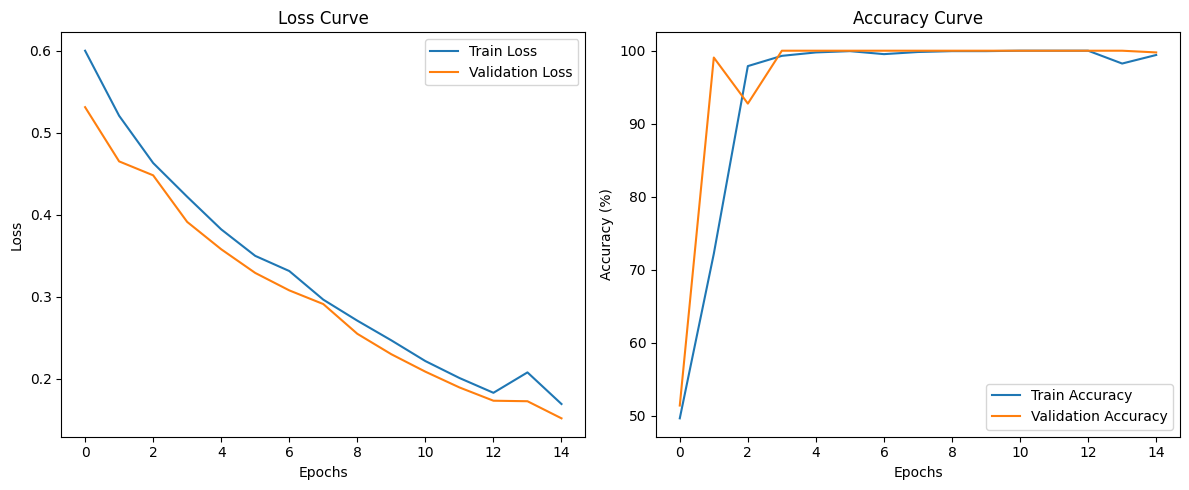

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

# Save figure (high resolution)
plt.tight_layout()
plt.savefig("training_curves.png", dpi=300)  # saves in current working directory

plt.show()


# Classification Report

Classification Report:

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00       208
        sick       1.00      1.00      1.00       220

    accuracy                           1.00       428
   macro avg       1.00      1.00      1.00       428
weighted avg       1.00      1.00      1.00       428



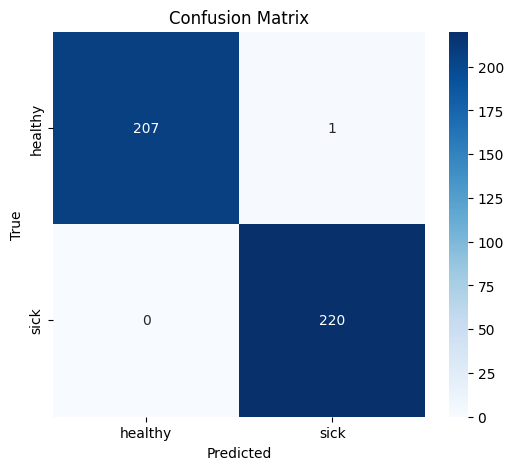

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume model is already trained

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['healthy', 'sick']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['healthy', 'sick'],
            yticklabels=['healthy', 'sick'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Accuracy

In [17]:
import torch

def evaluate_accuracy(model, dataloader, device):
    model.eval()  # evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # no gradient calculation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Example usage:
accuracy = evaluate_accuracy(model, valloader, device)

Accuracy: 99.77%


# Classification Report + ROC Curve

In [13]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in valloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Predicted labels
        _, preds = torch.max(outputs, 1)

        # Probabilities (apply softmax)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 'sick'

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# -----------------------------
# 1. Classification Report
# -----------------------------
report = classification_report(all_labels, all_preds, target_names=['healthy', 'sick'])
print(report)

# -----------------------------
# 2. Confusion Matrix
# -----------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['healthy', 'sick'],
            yticklabels=['healthy', 'sick'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")   # save instead of show
plt.close()

# -----------------------------
# 3. ROC Curve
# -----------------------------
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
plt.close()

# -----------------------------
# 4. Generate PDF Report
# -----------------------------
doc = SimpleDocTemplate("Evaluation_Report.pdf", pagesize=A4)
styles = getSampleStyleSheet()
elements = []

elements.append(Paragraph("Model Evaluation Report", styles['Title']))
elements.append(Spacer(1, 20))

# Add classification report as text
elements.append(Paragraph("Classification Report:", styles['Heading2']))
for line in report.split("\n"):
    elements.append(Paragraph(line, styles['Normal']))
elements.append(Spacer(1, 20))

# Add confusion matrix image
elements.append(Paragraph("Confusion Matrix:", styles['Heading2']))
elements.append(Image("confusion_matrix.png", width=400, height=300))
elements.append(Spacer(1, 20))

# Add ROC curve image
elements.append(Paragraph("ROC Curve:", styles['Heading2']))
elements.append(Image("roc_curve.png", width=400, height=300))

doc.build(elements)

print("✅ Report saved as Evaluation_Report.pdf")


              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00       208
        sick       1.00      1.00      1.00       220

    accuracy                           1.00       428
   macro avg       1.00      1.00      1.00       428
weighted avg       1.00      1.00      1.00       428

✅ Report saved as Evaluation_Report.pdf


# Misclassified Samples

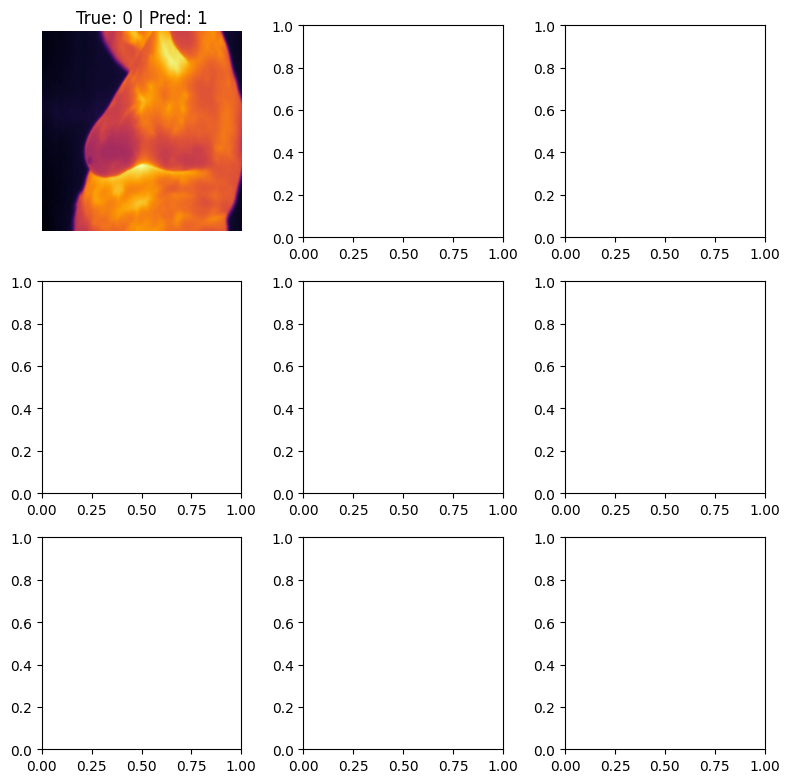

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(8,8))
axes = axes.ravel()

misclassified = []
with torch.no_grad():
    for inputs, labels in valloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for img, label, pred in zip(inputs, labels, preds):
            if label != pred:
                misclassified.append((img.cpu(), label.cpu(), pred.cpu()))

for i, (img, label, pred) in enumerate(misclassified[:9]):
    axes[i].imshow(img.permute(1,2,0))
    axes[i].set_title(f"True: {label.item()} | Pred: {pred.item()}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


# Prediction

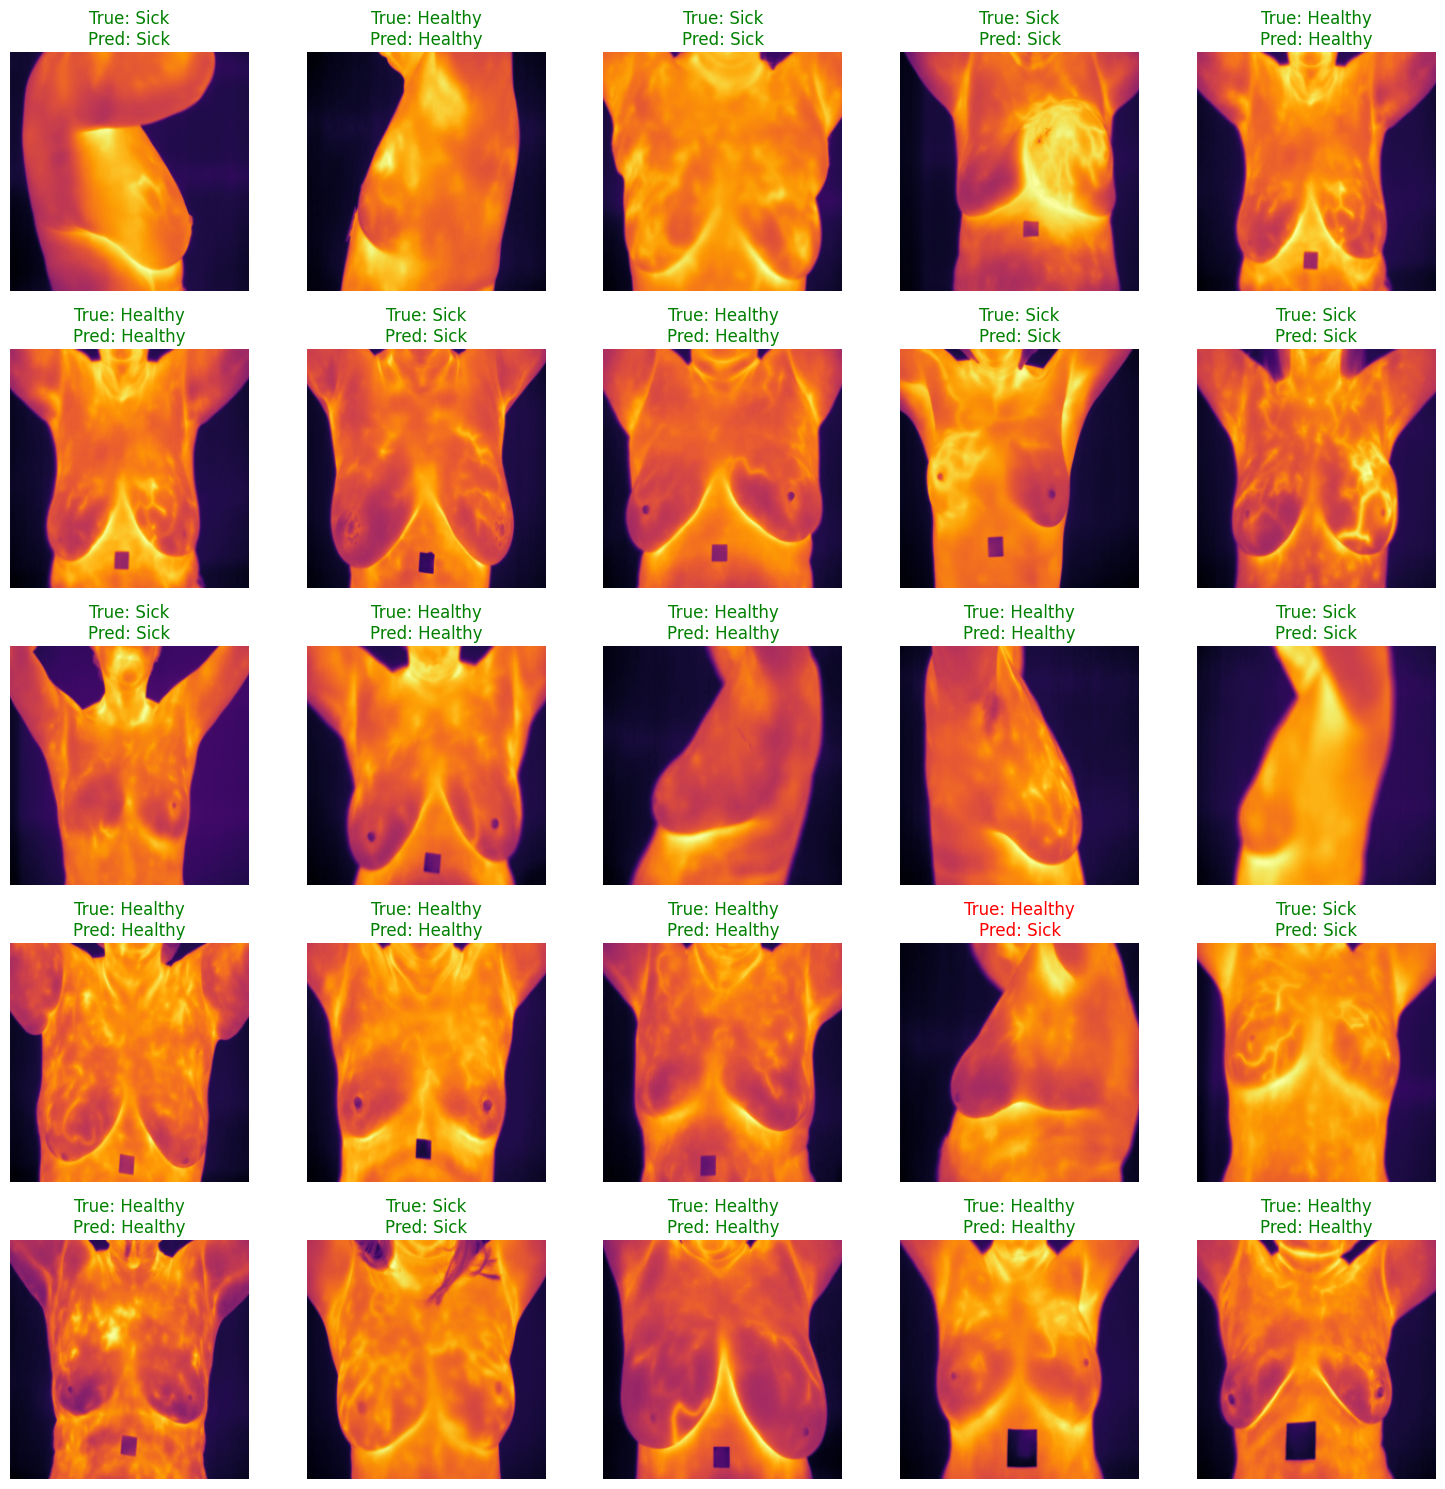

✅ Prediction grid saved as predictions.png


In [15]:
import random
import matplotlib.pyplot as plt
import torch

# Class mapping
class_names = {0: "Healthy", 1: "Sick"}

def predict_random_images(model, dataloader, device, num_images=25, save_path="prediction_grid.png"):
    model.eval()
    images, labels = [], []

    # Collect all images and labels from the dataloader
    for inputs, targets in dataloader:
        for i in range(inputs.size(0)):
            images.append(inputs[i])
            labels.append(targets[i])

    # Pick random indices
    random_indices = random.sample(range(len(images)), num_images)

    # Create subplots
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()

    with torch.no_grad():
        for idx, ax in zip(random_indices, axes):
            img = images[idx].unsqueeze(0).to(device)  # add batch dim
            true_label = labels[idx].item()

            output = model(img)
            _, predicted = torch.max(output, 1)
            pred_label = predicted.item()

            # Convert tensor image to numpy for visualization
            img_np = images[idx].cpu().numpy().transpose(1, 2, 0)
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # normalize for display

            ax.imshow(img_np.squeeze(), cmap="inferno")  # thermal style
            ax.axis("off")
            ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                         color="green" if true_label == pred_label else "red")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # Save as image
    plt.show()

    print(f"✅ Prediction grid saved as {save_path}")

# Example usage:
predict_random_images(model, valloader, device, num_images=25, save_path="predictions.png")


# Model visualization

In [24]:
import torch
from torchviz import make_dot

# Assuming your model is already defined and loaded
# Example: model = MyModel()
# model.load_state_dict(torch.load("mymodel.pth"))

model.eval()

# Create a dummy input (must match your model’s input shape!)
dummy_input = torch.randn(1, 3, 224, 224)   # Example: for image model with 3 channels, 224x224 size

# Forward pass
output = model(dummy_input)

# Create graph
dot = make_dot(output, params=dict(model.named_parameters()))

# Show inside Jupyter
dot

# Save as PNG (or PDF, SVG, etc.)
dot.render("my_model_graph", format="png")


'my_model_graph.png'

# Save Model

In [16]:
# Save model
torch.save(model.state_dict(), "thermal_QNN_model.pth")
